In [33]:
import numpy as np
from SERGIO.GRN import grn_from_human,grn_from_networkx
from SERGIO._sergio import sergio
from SERGIO.MR import mrProfile
import networkx as nx
from collections import defaultdict
import pandas as pd
from SERGIO.GRN._grn import GRN
from SERGIO.GRN._components import Gene, SingleInteraction
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import copy
def create_random_graph(N):
    '''N:number of nodes
    Note that the number of nodes in the graph will likely be smaller than N
    Weights sampled from 2 uniform distributions
    '''
    weight_pos = 3
    weight_neg = -weight_pos
    band=1
    frac_pos = 0.5 #fraction of positive links over total
    G = nx.generators.random_k_out_graph(n = 100,k = 4,alpha = 0.9)
    largest = max(nx.strongly_connected_components(G), key=len)
    G = G.subgraph(largest).copy()#filter graph to maximum  SCC
    G = nx.DiGraph(G)#remove multi links
    M = len(G.edges())#n. of links
    w1 = np.random.uniform(weight_neg-band,weight_neg+band,int(M*frac_pos))#sample weights from 2 uniform distributions
    w2 = np.random.uniform(weight_pos-band,weight_pos+band,M-len(w1))
    w = np.concatenate([w1, w2])
    random.shuffle(w)#avoid having correlation in the position
    J = nx.adjacency_matrix(G)
    J.data = w
    G = nx.from_scipy_sparse_matrix(J,create_using=nx.DiGraph())
    return G

In [13]:
#grn = grn_from_human(nGenes=20)
G = 
G = grn.to_networkx()
len(G)

33

In [14]:
grn0 = copy.deepcopy(grn)#it is the grn that I pass to perturbation experiments

In [15]:
def perturbation_all(grn,nCells):
    nGenes = len(grn.attr_['genes'])
    store = np.zeros(shape = (2,nGenes,nGenes,nCells))
    #dimension 0 describe the type of perturbation experiment, 0:Crispri, 1: crispra
    #dimension 1 describes the index target gene
    #dimension 2 describe the index of genes whose expression is measured
    #dimension 3 describes the index of cell
    
    '''now simulate wild type'''
    grn0 = copy.deepcopy(grn)#it is the grn that I pass to perturbation experiments
    mrs = grn.get_mrs()
    mr_profs = mrProfile(MR_names = mrs, n_types = 1)
    mr_profs.build_rnd(range_dict={'L': [1, 2.5], 'H': [3.5, 5]})
    grn.init(mr_profs, update_half_resp = True)
    sim = sergio(grn)
    sim.simulate(nCells = nCells, noise_s = 1, safety_iter = 150, scale_iter = 10)
    wt = sim.getSimExpr().values
    for i,target_gene in enumerate(grn.attr_['genes'].keys()):
        #simulate Crispri
        store[0,i]= single_perturbation(grn = grn0,mr_profs=mr_profs,target_gene=target_gene,basal_prod=0.2,nCells=nCells,cutting=True).getSimExpr().values
        #simulate Crispra
        store[1,i]= single_perturbation(grn = grn0,mr_profs=mr_profs,target_gene=target_gene,basal_prod=3,nCells=nCells,cutting=True).getSimExpr().values

    return wt,store
def single_perturbation(grn,mr_profs,target_gene,basal_prod,nCells,cutting = True):
    '''
    Function Description:

    This function perturbs a given gene in a gene regulatory network (GRN) and returns
    the simulated dynamics of the network in response to the perturbation. The perturbation involves
    changing the production rate of the target gene to a given basal level (positive for CRISPRa,
    negative or 0 for CRISPRi), and optionally, cutting incoming edges to the target gene.
    The function returns the simulated gene expression dynamics of the perturbed network.

    Parameters:

    grn: an instance of the GRN class representing the GRN to be perturbed
    mr_profs: an instance of the mrProfile class representing the master regulator profiles of the system
    target_gene: the name of the target gene to be perturbed
    basal_prod: the basal production rate of the target gene after perturbation (positive for CRISPRa, negative or 0 for CRISPRi)
    cutting: a boolean variable indicating whether incoming edges to the target gene should be cut (True) or not (False)
    in response to the perturbation. Default is True.
    Returns:

    sim: an instance of the sergio class representing the simulated gene expression dynamics of the perturbed network.
    
    '''
    new_grn = copy.deepcopy(grn)
    new_grn.attr_['mrs'].add(target_gene)
    links_2_remove = list(filter(lambda x:x.split('-')[1]==target_gene,new_grn.attr_['interactions'].keys()))
    if cutting:
        #identifies the links pointing to gene, and removes them from the net
        [new_grn.attr_['interactions'].pop(link) for link in links_2_remove]#remove interaction from GRN
    
    crispri = copy.deepcopy(mr_profs)
    crispri.profile[target_gene]=basal_prod*np.ones(1)
    new_grn.init(crispri, update_half_resp = True)
    sim = sergio(new_grn)
    sim.simulate(nCells = nCells, noise_s = 1, safety_iter = 150, scale_iter = 10)
    return sim
%time wt,store = perturbation_all(grn0,nCells=1000)

CPU times: user 7min 13s, sys: 28 ms, total: 7min 13s
Wall time: 7min 13s


In [17]:
store.shape,wt.shape
gene_list = list(grn.attr_['genes'].keys())

4780


[('4780', '2938', {'weight': 1}),
 ('4780', '2939', {'weight': 1}),
 ('4780', '2940', {'weight': 1}),
 ('4780', '2941', {'weight': 1}),
 ('4780', '221357', {'weight': 1}),
 ('4780', '2944', {'weight': 1}),
 ('4780', '2946', {'weight': 1}),
 ('4780', '2947', {'weight': 1}),
 ('4780', '2948', {'weight': 1}),
 ('4780', '2949', {'weight': 1}),
 ('4780', '9446', {'weight': 1}),
 ('4780', '119391', {'weight': 1}),
 ('4780', '2950', {'weight': 1}),
 ('4780', '2952', {'weight': 1}),
 ('4780', '2953', {'weight': 1}),
 ('4780', '653689', {'weight': 1}),
 ('4780', '3162', {'weight': 1}),
 ('4780', '4257', {'weight': 1}),
 ('4780', '4258', {'weight': 1}),
 ('4780', '4259', {'weight': 1}),
 ('4780', '1728', {'weight': 1}),
 ('4780', '7296', {'weight': 1}),
 ('4780', '10587', {'weight': 1}),
 ('4780', '114112', {'weight': 1}),
 ('4780', '445', {'weight': 1}),
 ('4780', '4846', {'weight': 1}),
 ('4780', '4880', {'weight': 1}),
 ('4780', '5327', {'weight': 1}),
 ('4780', '8878', {'weight': 1}),
 ('478

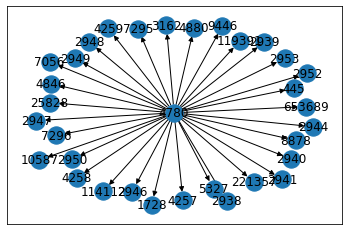

In [20]:
gene_view = gene_list[1]
nx.draw_networkx(nx.ego_graph(G,gene_view,undirected=True))
print(gene_view)
list(G.out_edges(gene_view,data=True))


<AxesSubplot:ylabel='Count'>

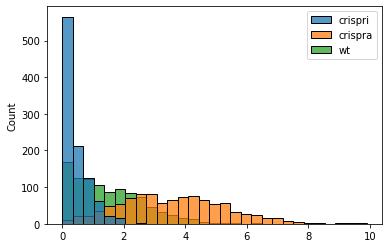

In [23]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
j = np.arange(len(gene_list))[np.array(gene_list)==list(G.out_edges(gene_view))[2][1]][0]#take the index of one of the genes neighbouring gene_view

a = pd.DataFrame({'crispri':store[0,i,j],'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a)

<AxesSubplot:ylabel='Count'>

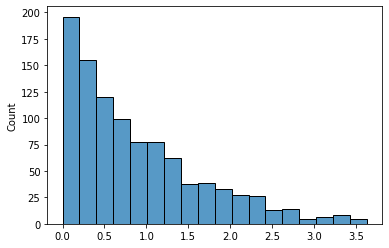

In [74]:
sns.histplot(store[1,i,j])

In [164]:
pd.DataFrame([[i,v.prod_rates_[0]] for i,v in sim2.grn_.attr_['genes'].items()if v.prod_rates_ is not None] ,columns= ['MR_id','prod_rate'])

,MR_id,prod_rate
0,2737,3.582154
1,4853,4.081881
2,900,5.000000
3,7161,1.538699
4,3135,2.003430
5,3164,1.158086
6,9572,2.282716
7,5598,1.877689
8,5602,4.718141
9,50674,2.268740


In [129]:
sim2.grn_.attr_['genes'][gene]._calc_prod([0], regs_conc = 'sim')
sim2.grn_.attr_['genes'][gene].prod_rates_

array([5.])

In [13]:
sim2.grn_.attr_['genes'][gene].isMR_,sim.grn_.attr_['genes'][gene].isMR_


(True, False)

In [30]:
if sim2.grn_.attr_['genes'][list(non_mr)[0]].prod_rates_ is not None:
    print('None')

None


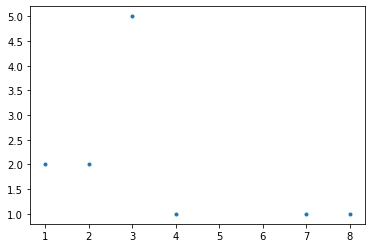

In [156]:
sim2.grn_.attr_['genes'][gene].level,
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in mrs ]).items())),'.')


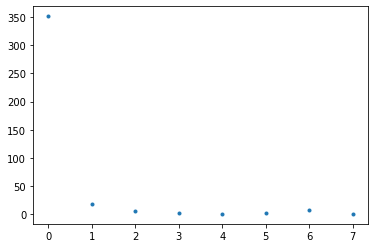

In [159]:
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in non_mr if el!=gene]).items())),'.')


In [32]:
#len(sim.grn_.attr_['genes'])
len(grn.attr_['genes']),len(grn.attr_['interactions'])

(33, 32)

In [30]:
for a,b in grn.attr_['interactions'].items():
    print(b.k_)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
